# Amazon Review NLP Proj - Tutorial
### Full credit of tutorial to DPhi on youtube: https://www.youtube.com/watch?v=o1Bb7G4szQQ

Miranda-Calle, Julián Darío, IPython notebook: Introduction to NLP with Sentiment ANalysis, July 2020, URL: https://github.com/juliandariomirandacalle/NLP_Notebooks

In [79]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

We will be working with a .csv file that contains information about tens of thousands of customers writing reviews on Amazon products every day. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). In this way, the following attributes are available in the data:

1. **ProductId (categorical):** ID of the referenced product by the customer.
2. **UserId (categorical):** registered user ID.
3. **ProfileName (text):** registered user profile name.
4. **HelpfulnessNumerator (numerical):** number of users who found the review helpful.
5. **HelpfulnessDenominator (numerical):** Number of users who voted whether the review was helpful or not.
6. **Score (ordinal):** rating between 1 and 5.
7. **Time (numerical):** timestamp of the review.
8. **Summary (text):** brief summary of the review.
9. **Text (text):** text of the review.    

## Running basic EDA on the data to visualize what we are working with

In [11]:
amzn_rev = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
amzn_rev.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Counting the number of words per review using the 'Text' column

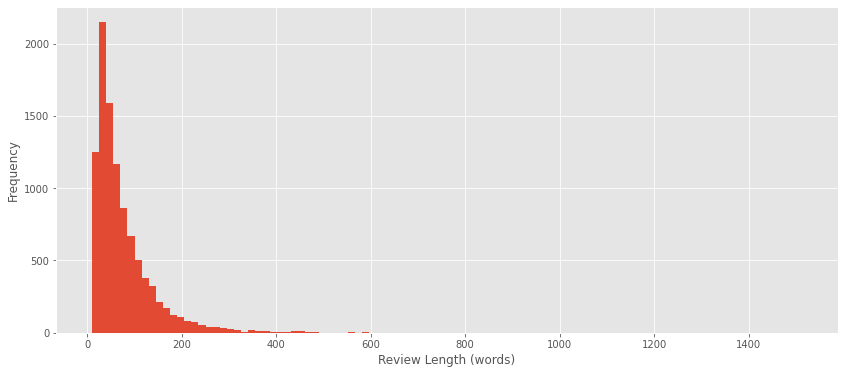

In [3]:
words_per_rev = amzn_rev.Text.str.count(' ').add(1)
words_per_rev.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [4]:
print('Average words:',words_per_rev.mean())
print('Skewness:', words_per_rev.skew())

Average words: 77.9028
Skewness: 4.612459483340116


We can see that the graph is heavily skewed to the left, with the majority of the reviews being under 200 words. We can also see that the mean number of words is approximately 78, so we will most likely omit reviews with over 200 words.

In [5]:
counts_per_score = amzn_rev.Score.value_counts()
print(counts_per_score)

5    6183
4    1433
1     932
3     862
2     590
Name: Score, dtype: int64


#### Counting the number of reviews for each star/rank level 1-5

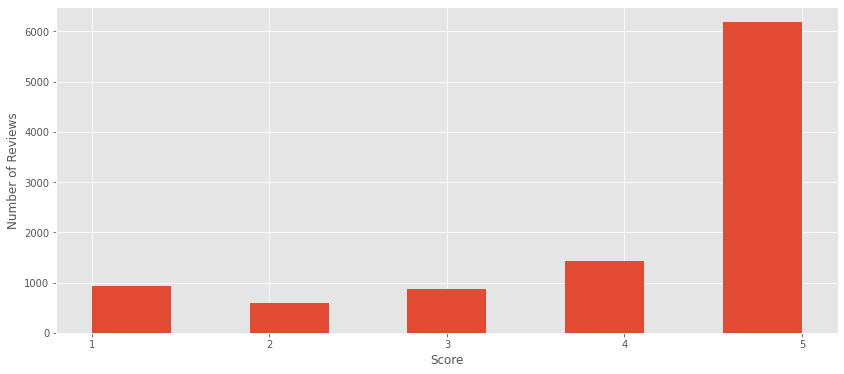

In [6]:
amzn_rev.Score.hist(bins=9)
plt.xticks([1,2,3,4,5])
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.show()

We can see that the rank with the most reviews is 5 star, followed by the 4 star, then 1, 3, and finally 2 stars. We can visualize the percentage of reviews which each star takes up with a pie chart.   

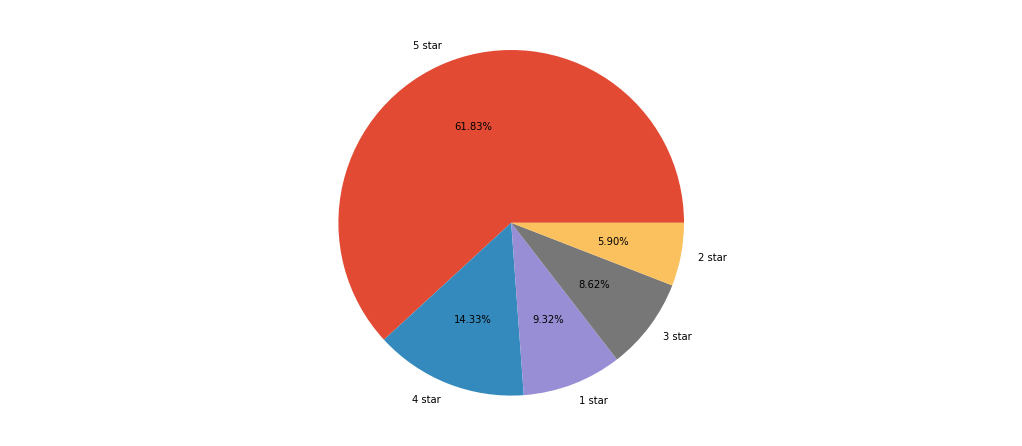

In [36]:
percent_rev = 100 * amzn_rev.Score.value_counts()/len(amzn_rev)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
scores = ['5 star', '4 star', '1 star', '3 star', '2 star']
percent = percent_rev
ax.pie(percent, labels = scores ,autopct='%1.2f%%')
plt.show()

### Text Visualization with WordCloud
We want to know what words appear more frequently in the reviews, and judge the reviews based on the importance of these key words.

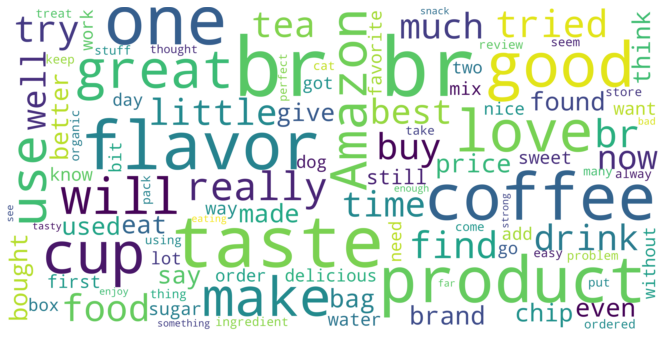

In [39]:
word_cloud_text = ''.join(amzn_rev['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

Note that with many of the reviews in the cloud, we can deduce that many of these reviews are talking about food-related items. We can see this through the larger words such as coffee, taste, flavor, make, product, ans even smaller words such as snack, sugar, and many more.

We also see the use of many filler words such as one, well, see, and something. There is also the break element br in HTML which is a commonly used 'word'. We may have to clean the text to get rid of these.

### Standardizing the ratings for sentiment analysis
For the purposes of sentiment analysis, we will convert all of the ratings to binary values 1 and 0, which represent good/positive and bad/negative reviews respectfully.

- Any review with > 3 stars is a 1
- Any review with < 3 stars is a 0
- Any review with 3 stars is considered neutral, so we negate these.

In [43]:
amzn_rev['Sentiment_rating'] = np.where(amzn_rev.Score > 3,1,0)

## Removing neutral reviews 
amzn_rev = amzn_rev[amzn_rev.Score != 3]

# Printing the counts of each class
amzn_rev.Sentiment_rating.value_counts()

1    7616
0    1522
Name: Sentiment_rating, dtype: int64

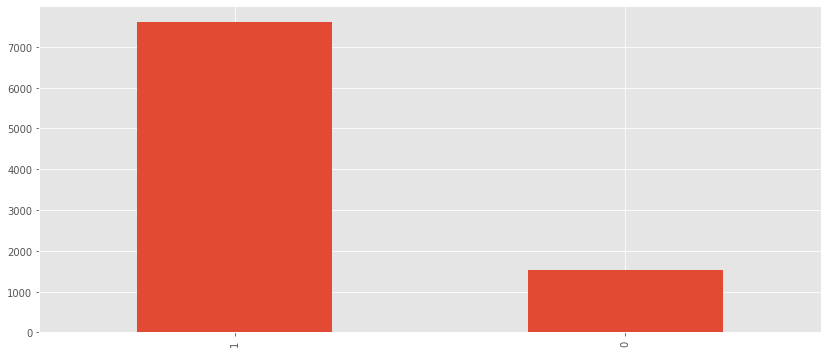

In [43]:
amzn_rev.Sentiment_rating.value_counts().plot.bar()
plt.show()

As we can see, there are many more positive reviews than negative reviews. We will address this issue in the future

### Pre-processing
As discussed previously, text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization

#### 1. Converting words to lowercase
We will start by converting all the words to lowercase, to make all the words uniform.

In [12]:
amzn_rev['reviews_text_new'] = amzn_rev.Text.str.lower()

Next, we want to tokenize each word in the reviews

In [11]:
# Word tokenization example:
word_tokenize("My name is Krishna Shenoy :D")

['My', 'name', 'is', 'Krishna', 'Shenoy', ':', 'D']

In [14]:
# For reviews not converted to lowe case
token_lists = [word_tokenize(each) for each in amzn_rev['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in amzn_rev['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  28992
Number of unique tokens now:  23693


As we can see, the number of tokens decreases by a large portion of the original number, since we normalized the case of all the words/letters. This means that words such as "GREAT", "Great", and "great" would all be the same token.

'
Removing special characters is a subjective call, especially in cases like this one. People often use special characters to express their emotions and might leave a review like 'This product is the worst!!!', while a positive review could be like 'This product is the best. Loved it!'. Here, the presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them may well not be a good idea.

On the other hand, removing non-emotionally charged punctuation such as commas, periods, and semicolons is likely safe.
'

### Removing special chars

In [13]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = amzn_rev['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '¢',
 '§',
 '®'}

Note that the above list represents all the special characters that we would like to clean from our reviews_text_new column. The following is a comparison between an old review with special characters, and a new review with the special characters removed. We do this with a test column to ensure it works, before moving onto the real dataframe.

In [25]:
test = amzn_rev.reviews_text_new
test[2]

'this is a confection that has been around a few centuries.  it is a light, pillowy citrus gelatin with nuts - in this case filberts. and it is cut into tiny squares and then liberally coated with powdered sugar.  and it is a tiny mouthful of heaven.  not too chewy, and very flavorful.  i highly recommend this yummy treat.  if you are familiar with the story of c.s. lewis\' "the lion, the witch, and the wardrobe" - this is the treat that seduces edmund into selling out his brother and sisters to the witch.'

In [26]:
test = test.replace('[^a-zA-Z0-9 ]', '', regex=True)
test[2]

'this is a confection that has been around a few centuries  it is a light pillowy citrus gelatin with nuts  in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar  and it is a tiny mouthful of heaven  not too chewy and very flavorful  i highly recommend this yummy treat  if you are familiar with the story of cs lewis the lion the witch and the wardrobe  this is the treat that seduces edmund into selling out his brother and sisters to the witch'

**We can see that all the special characters have been replaced with a blank space (not a space character). Now, we can run the same function for our main df. We will still save test as the original value of the reviews_text_new column in case something goes wrong:**

In [14]:
test = amzn_rev.reviews_text_new
amzn_rev['reviews_text_new'] = amzn_rev['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [34]:
token_lists = [word_tokenize(each) for each in amzn_rev['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amzn_rev['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  28992
Number of unique tokens now:  18817


### Stopwords and high/low frequency words

From the wordcloud we created previously, we noticed that there were many irrelevent words that were used such as 'something', 'well' and 'see', among others. When running our analysis, these words have no meaning toward the star rating of each review, thus we would like to remove these **stopword**.

In [35]:
from nltk.corpus import stopwords
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Above, we can see the many english words that are considered stopwords by nltk.

In [38]:
def stopwords_removal(sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in eng_stop_words]

amzn_rev['reviews_text_nonstop'] = amzn_rev['reviews_text_new'].apply(lambda row: stopwords_removal(row))
amzn_rev[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price there was a wid...,"[great, taffy, great, price, wide, assortment,..."
...,...,...
9995,we switched from the advance similac to the or...,"[switched, advance, similac, organic, product,..."
9996,like the bad reviews say the organic formula ...,"[like, bad, reviews, say, organic, formula, co..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."
9998,i love the fact that i can get this delieved t...,"[love, fact, get, delieved, house, delievy, ch..."


### Stemming and Lemmatization

Often times, words can be written in different tenses and contexts, but have the same meanign. for example, the word "turn" can be written as "turning", "turn", "turned". All these words mean the same thing, but will be tokenized as individual words.

**Stemming:** This takes words such as "turn", "turned", and "turning", and cuts off the end letters until all 3 words are the same. In this case, we will cut off the **ed** in turned, and the **ing** in turning, to get turn.

**Lemmatization:** Takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [20]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kishnashenoy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In the following example, we will illustrate an example of **stemming** vs. **lemmatization**.

In [28]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


Note that while taking into account the context and use of the words, the lemmatizer returns the actual word, rather than cutting off letters like the stemmer.

### Building a Machine Learning Model

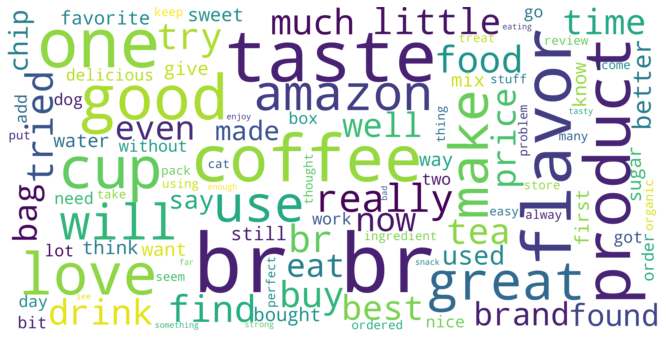

In [9]:
word_cloud_text = ''.join(amzn_rev['reviews_text_new'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

Note that we still have the line break HTML element br in the text. We will remove it in the following line

In [10]:
test = amzn_rev['reviews_text_new'].copy()
amzn_rev['reviews_text_new'] = amzn_rev['reviews_text_new'].str.replace('br ', ' ')

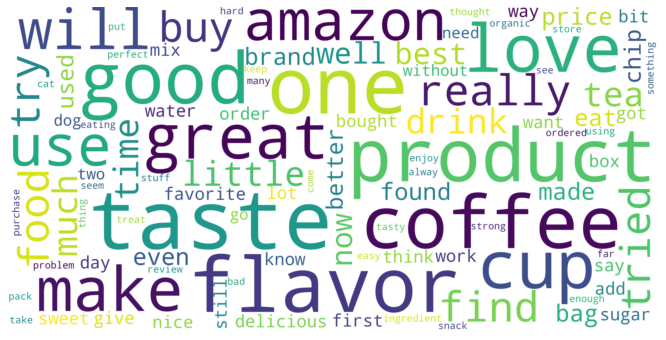

In [11]:
word_cloud_text = ''.join(amzn_rev['reviews_text_new'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

Note that we do not have the br in the wordcloud at all.

In [15]:
token_lists = [word_tokenize(each) for each in amzn_rev['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amzn_rev['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  28992
Number of unique tokens now:  18816


In fact, the last time we ran the above code, we had 28992 tokens **then**, and 18817 tokens **now**. This time, we have the same number of tokens then, with 1 less tokens now (18816). This indicates that we have successfully removed the line break tag "br" from the text.

#### Bag-of-words

In [49]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(amzn_rev['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,...,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=eng_stop_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(amzn_rev['reviews_text_new'])

In [51]:
bow_data

<9138x17890 sparse matrix of type '<class 'numpy.int64'>'
	with 297831 stored elements in Compressed Sparse Row format>

From here, we know that we have 9138 reviews in revies_text_new, and 17890 individual words.

Now, we split the data into train and test data.

In [53]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    amzn_rev['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [54]:
y_test_bow.value_counts()/len(y_test_bow)

1    0.847921
0    0.152079
Name: Sentiment_rating, dtype: float64

From this, we can see that in the test data, approximately 85% of the reviews have a star rating over 3 stars, or in other words, a sentiment rating of 1. This also means that if we were to classify all of our reviews as positive, we would have an accuracy of approximately 85%. This is the baseline that our model should aim to beat.

### Apply Logistic Regression

In [65]:
# Training the model:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_bow, y_train_bow)

# Making predictions on the entire dataset:
predictions = logisticRegr.predict(X_test_bow)

# Calculate key performance metrics:
print("F1 score: ", f1_score(y_test_bow, predictions))

F1 score:  0.9507467429297743


**To explain the F1 score, we use the definition given by sklearn itself:**
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall

We will now analyze which features had the most "weight" when the algorithm was making these predictions.

In [67]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   logisticRegr.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names
lr_weights.sort_values(['weights'], ascending=False)[:15]

,words,weights
11655,perfect,1.827973
14583,smooth,1.754174
5955,excellent,1.743346
11937,pleased,1.667409
4668,delicious,1.616526
998,amazing,1.588500
2043,best,1.581509
7350,great,1.507438
17620,wonderful,1.429536
13028,refreshing,1.411940


In [68]:
lr_weights.sort_values(['weights'], ascending=False)[-15:]

,words,weights
8371,ingredient,-1.309288
17303,waste,-1.334327
12064,popped,-1.367345
12853,realize,-1.382498
10505,mushy,-1.391859
4999,disappointment,-1.529585
1496,awful,-1.581021
13382,return,-1.617116
7422,grounds,-1.618169
7956,horrible,-1.662493


In [70]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amzn_rev.reviews_text_new)

In [71]:
bow_data

<9138x1261413 sparse matrix of type '<class 'numpy.int64'>'
	with 2530528 stored elements in Compressed Sparse Row format>

We see that increasing the n-grams increased the number of words/phrases significantly

In [73]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    amzn_rev['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [81]:
# Defining and training the model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_bow, y_train_bow)

# Predicting the results
predictions = logisticRegr.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, predictions))

F1 score:  0.9541745134965474


Note that the F1 score has slightly increased. This is due to use increasing the number of strings we take into account

In [82]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   logisticRegr.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names
lr_weights.sort_values(['weights'], ascending=False)[:15]

,words,weights
448809,great,1.327952
305794,delicious,0.952382
810997,perfect,0.838341
438773,good,0.831986
1023733,the best,0.820529
358331,excellent,0.820490
171393,best,0.792892
639088,love,0.783855
709971,nice,0.769360
930961,smooth,0.637418


In [83]:
lr_weights.sort_values(['weights'], ascending=False)[-15:]

,words,weights
1241695,worst,-0.542746
1175374,very disappointed,-0.558028
1206112,were,-0.564676
874505,return,-0.568146
143979,away,-0.573349
959625,stick,-0.585500
144964,awful,-0.593924
1193585,waste,-0.612398
317336,disappointing,-0.613684
982546,t,-0.674739
